In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from astroquery.alma import Alma
from astroquery.ned import Ned
from astropy import units as u
from astropy.coordinates import SkyCoord
import warnings
warnings.filterwarnings("ignore")
from importlib import reload

rcParams['figure.figsize'] = (16, 7.5)
rcParams['ytick.labelsize'],rcParams['xtick.labelsize'] = 17.,17.
rcParams['axes.labelsize']=19.
rcParams['legend.fontsize']=17.
rcParams['axes.titlesize']=20.

In [2]:
cd ..

/home/astromix/astro/alma-sample


In [3]:
from src.tools import bands
from src.tools import foo
from src.tools import models

In [237]:
import pymc3 as pm

In [38]:
loge=np.log10(np.e)
h=6.62606885e-27#6.62606885e-34 #J*s
c=2.99792458e10 #cm/s
kb=1.3806504e-16#1.38e-23 #J/K
R=2.*h/c**2#*0.4*4760936029312642.0#*5.2502279648982366e-52
logR=np.log10(R)
log10=np.log(10)
log04=np.log10(0.4)
Lo=3.826e33 #erg/s to Lo
jy =1e23#1e26 #si to Jy
logjy=np.log10(jy)
Mo=3.068624e34
Mpctocm=3.086e24
Mpc2HzJy = 9.521e25 #Mpc^2 Hz Jy to erg/s
GtoR =5.7e36

def k(nu,a):
    return 0.4*(nu/250e9)**a
def _logk(lognu,a):
    return log04+a*lognu-a*np.log10(250e9)
def BB(nu,T):
    return jy*R*nu**3/(np.exp(h*nu/(kb*T))-1.)

def _logBB(lognu,T):
    nu=10**lognu
    return logjy+logR+3*lognu -np.log10(np.exp(h*nu/(kb*T))-1.)

def _nuGB(nu,T,logM,a,D):
    """
    Grey Body for thin \tau
    \nu F_\nu (\nu ; A,a,T)= A R \frac{\nu ^{4+a}}{e^\frac{h\nu}{k T}-1}
    """
    Dcm=3.08e24*D
    Mg=2e33*10**logM
    return nu*k(nu,a)*Mg*BB(nu,T)/Dcm**2

def _lognuGB(lognu,T,logM,a,D):
    """
    \log \nu F_\nu (\log\nu ; \log A,a,T)= \log A +\log R  + (4+a) \log \nu -\log \big( e^\frac{h\nu}{k T}-1 \big)
    """
    #nu=10**lognu
    logDcm=np.log10(3.08e24*D)
    logMg=np.log10(2e33)+logM
    return lognu+_logk(lognu,a)+logMg+_logBB(lognu,T)-2.*logDcm

def _lognuplcf(lognu,logB,b,lognuc):
    """
    \log \nu F_\nu (\log \nu ; \log B,b,\log \nu_c)= \log B+ (b+1) \log \nu -\frac{10^{\log \nu-\log \nu_c}}{\log 10}
    """
    return logB +lognu+b*lognu-10.**(lognu-lognuc)*loge
        

def _lognuRIR(lognu,T1,T2,T3,logM1,logM2,logM3,a1,a2,a3,logB,b,lognuc,D):
    GBs=np.log10(10**_lognuGB(lognu,T1,logM1,a1,D)+10**_lognuGB(lognu,T2,logM2,a2,D)+10**_lognuGB(lognu,T3,logM3,a3,D))
    return GBs+10**_lognuplcf(lognu,logB,b,lognuc)


In [54]:
x=np.linspace(8,14.5)
#x=np.logspace(8,14.5)

In [62]:
D=1000
Tr=120.
ar=2.
logMr=1
y=_lognuGB(x,Tr,logMr,ar,D)
y=y+np.random.normal(y,)

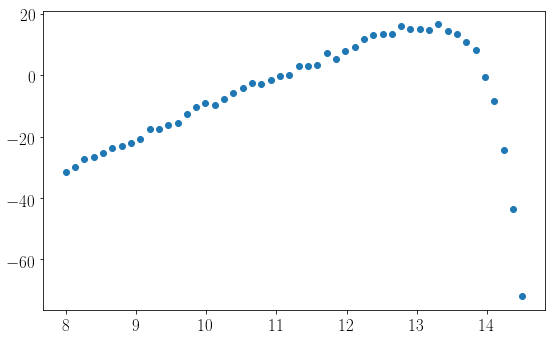

In [63]:
plt.plot(x,y,'o')

In [64]:
#reload(models)
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    T1=pm.Normal('T1',100,sd=10)
    #T2=Normal('T2',70,sd=15)
    #T3=Normal('T3',350,sd=50)
    
    a1=2.
    #a2=2.
    #a3=2.
    
    #b=Normal('b',-2,sd=1)
    #lognuc = Normal('lognuc',12,sd=1)
    logM1=pm.Normal('logM1',0,sd=3)
    #logM2=Normal('logM2',1,sd=3)
    #logM3=Normal('logM3',0,sd=3)
    #logB=Normal('logB',0,sd=5)
    #logA=Normal('logA',7.6,sd=4)
    sigma = pm.Gamma('sigma', alpha=1, beta=3)
    
    #mu = np.log10(10**_lognuGB(x,T1,logM1,a1,D)+10**_lognuGB(x,T2,logM2,a2,D)+10**_lognuGB(x,T3,logM3,a3,D))
    mu = _lognuGB(x,T1,logM1,a1,D)
    # Define likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=y)

    # Inference!
    trace = pm.sample(300, cores=4) # draw 3000 posterior samples using NUTS sampling

Only 300 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, logM1, T1]
Sampling 4 chains: 100%|██████████| 3200/3200 [00:01<00:00, 2804.16draws/s]
The acceptance probability does not match the target. It is 0.8788682879866722, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e58282eb8>,
      dtype=object)

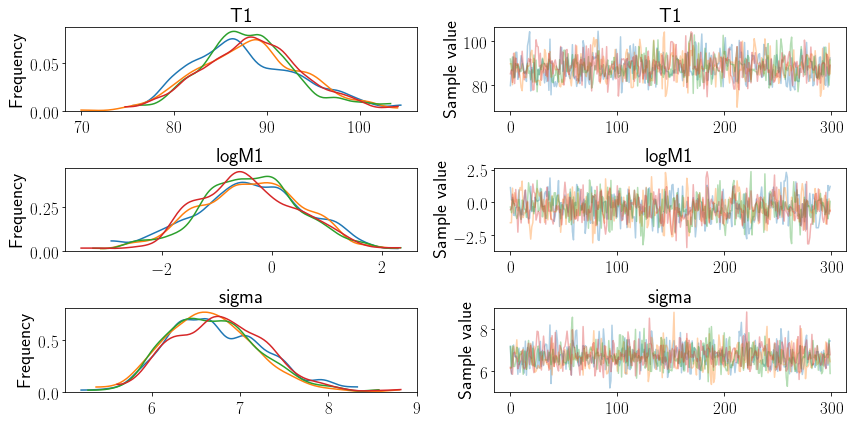

In [65]:
pm.traceplot(trace)

In [66]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
T1,88.17,5.49,0.18,78.09,99.59,921.89,1.0
logM1,-0.42,0.98,0.03,-2.45,1.43,901.86,1.0
sigma,6.71,0.53,0.02,5.81,7.79,1173.97,1.0


In [53]:
for RV in model.basic_RVs:
    print(RV.name, RV.logp(model.test_point))

T1 -3.2215236261987186
logM1 -2.0175508218727827
sigma_log__ -0.9999999801659125
y -3.2327236141600727e+18


In [260]:
mua=2.
siga=0.4
b=1.
x=np.linspace(1,10,20)
aa=np.random.normal(mua,siga,4)
y=np.array([])
for a in aa:
    y=np.append(y,a*x+b)
y=np.random.normal(y,0.75)

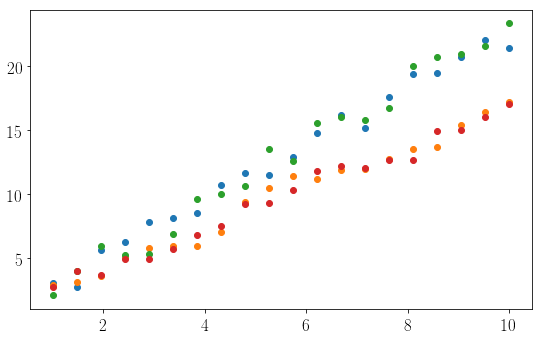

In [261]:
for i,a in enumerate(aa):
    plt.plot(x,y.reshape(len(aa),len(x))[i],'o')

In [262]:
d0=tuple(list(zip(x,y.reshape(len(aa),len(x))[0])))
for i in range(1,len(aa)):
    d0=np.vstack((d0,tuple(list(zip(x,y.reshape(len(aa),len(x))[i])))))

In [263]:
d0.shape

(80, 2)

In [274]:
data=d0[np.random.randint(0,d0.shape[0],50)]

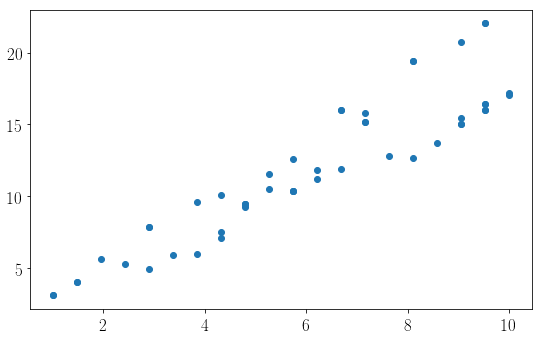

In [275]:
plt.plot(data[:,0],data[:,1],'o')

In [294]:
#reload(models)
x_data=data[:,0]
y_data=data[:,1]
with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    mua=pm.Normal('mua',1.5,sd=1)
    siga = pm.Normal('sigmaa',0.5, 0.4)
    a=pm.Normal('a',mua,sd=siga)
    b=pm.Uniform('b',-5,5)
    sigma = pm.Gamma('sigma', alpha=1, beta=0.5)
    #sigma=pm.TruncatedNormal('sigma',0.5,sd=0.3,lower=0.01,upper=2)
    
    mu = a*x_data+b
    # Define likelihood
    likelihood = pm.Normal('y', mu=mu, sd=sigma, observed=y_data)

    # Inference!
    trace = pm.sample(3000, cores=1,tune=1000) # draw 3000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, b, a, sigmaa, mua]
100%|██████████| 4000/4000 [00:05<00:00, 700.42it/s]
There were 649 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1207 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


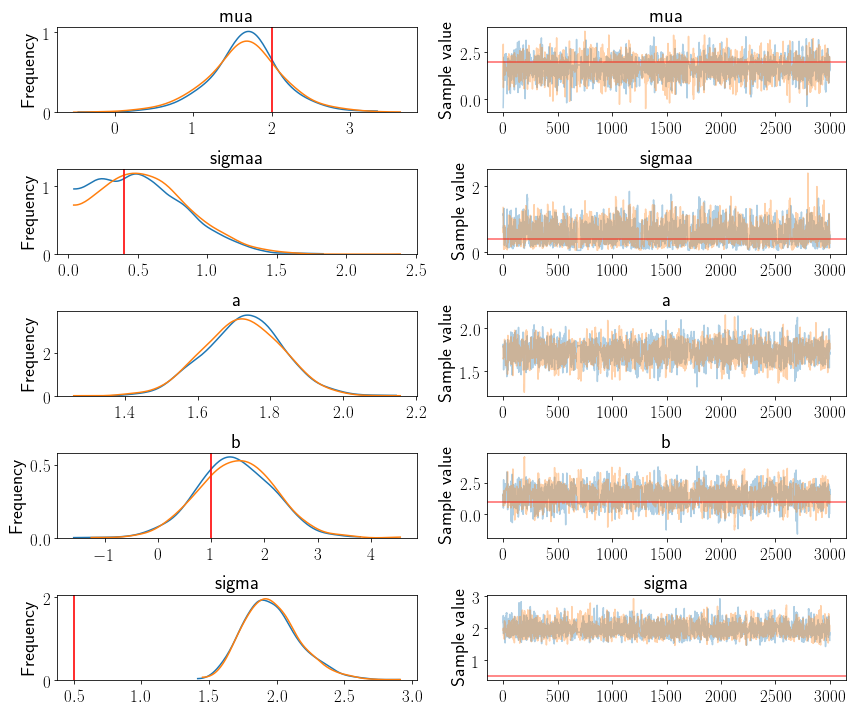

In [295]:
pm.traceplot(trace,lines={'mua':2,'sigmaa':0.4,'b':1,'sigma':0.5});

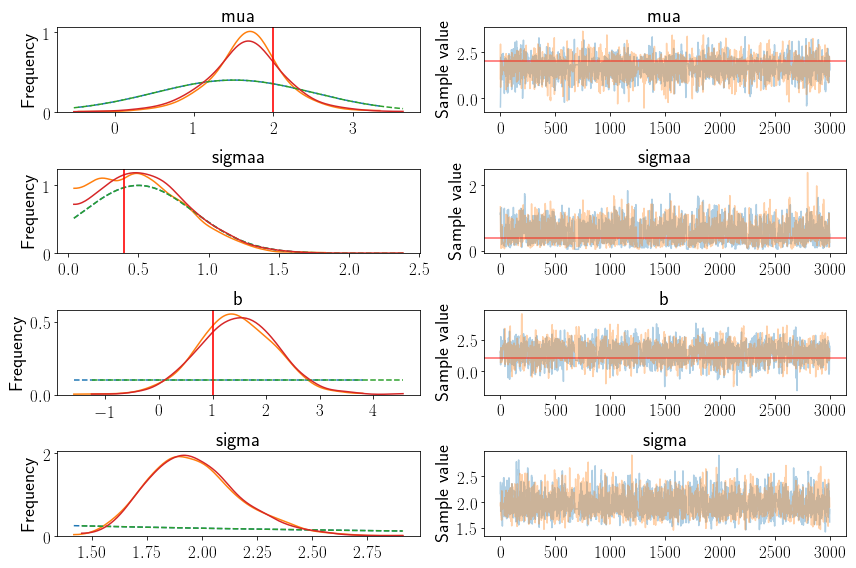

In [296]:
pm.traceplot(trace,varnames=['mua','sigmaa','b','sigma'],priors=[mua.distribution,siga.distribution,b.distribution,sigma.distribution],lines={'mua':2,'sigmaa':0.4,'b':1});

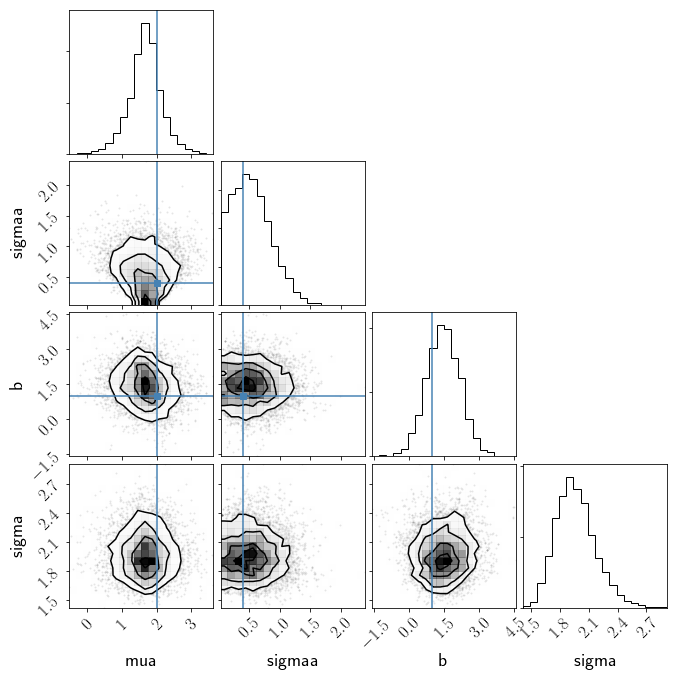

In [299]:
import corner
samples = np.vstack([trace[k] for k in ["mua", "sigmaa", "b","sigma"]]).T
corner.corner(samples, truths=[2,0.4,1,0.7],labels=['mua','sigmaa','b','sigma']);

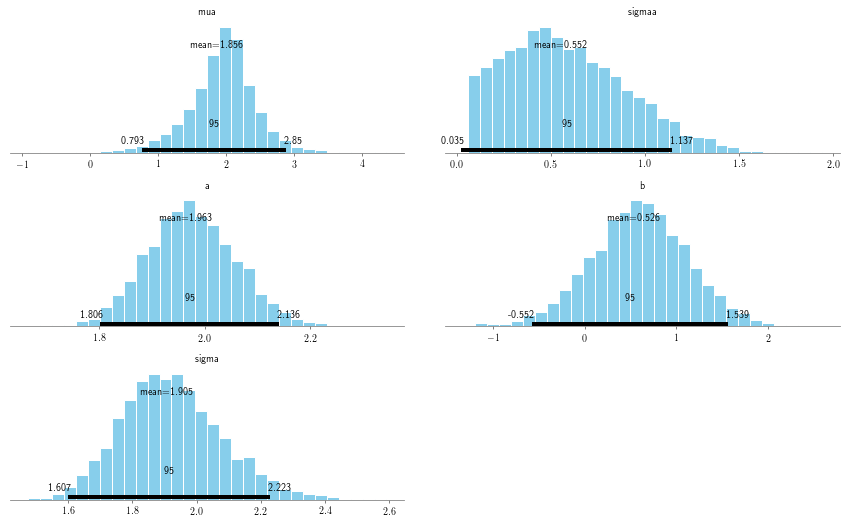

In [272]:
plot_posterior(trace);